# Imports

In [1]:
import numpy as np
import pandas as pd
import pickle


import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mtick

import cobra
from cobra import Metabolite, Reaction, Model
from cobra.util.array import create_stoichiometric_matrix
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import flux_variability_analysis
from benpy import vlpProblem
from benpy import solve as bensolve
from scipy.sparse import lil_matrix
from scipy.spatial import Delaunay
from scipy.spatial import distance

from functools import reduce 

import scipy.io as sio
from cobra.io.mat import _cell 
from collections import OrderedDict

from operator import itemgetter

from full_ecosystem import Ecosystem


# Toy example

The following example considers the computation of the abundance-growth space for a community comprised by two organisms (org1, org2) which reactions are displayed in the following figure:

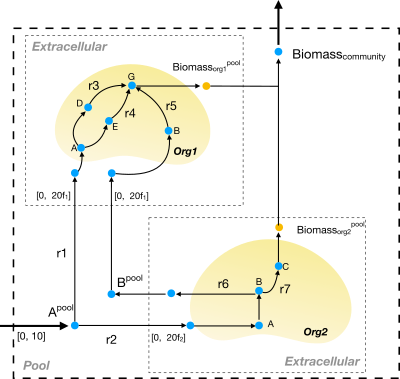

The example will start with construction of the models:

In [2]:
from cobra import Model, Reaction, Metabolite
#Organism 1:
model = Model('org1')

#A_ext -> A
reaction = Reaction('Atr')
model.add_reactions([reaction])
reaction.build_reaction_from_string('A_e -> A_c')

reaction = Reaction('EX_A')
model.add_reactions([reaction])
reaction.build_reaction_from_string('A_e -> ')
reaction.lower_bound = -1000

#B_ext -> B
reaction = Reaction('Btr')
model.add_reactions([reaction])
reaction.build_reaction_from_string('B_e -> B_c')


#EX_B
reaction = Reaction('EX_B')
model.add_reactions([reaction])
reaction.build_reaction_from_string('B_e -> ')

#A -> E
reaction = Reaction('AE')
model.add_reactions([reaction])
reaction.build_reaction_from_string('A_c -> E_c')

#A -> D
reaction = Reaction('AD')
model.add_reactions([reaction])
reaction.build_reaction_from_string('A_c -> D_c')

#D -> G
reaction = Reaction('DG')
model.add_reactions([reaction])
reaction.build_reaction_from_string('D_c -> 4 G_c')

#E->G
reaction = Reaction('EG')
model.add_reactions([reaction])
reaction.build_reaction_from_string('E_c -> 2 G_c')


#B-> 10G
reaction = Reaction('BG')
model.add_reactions([reaction])
reaction.build_reaction_from_string('B_c -> 10 G_c')

#G-> bio
reaction = Reaction('Gbio')
model.add_reactions([reaction])
reaction.build_reaction_from_string('G_c -> biom1_c')


reaction = Reaction('biomass')
model.add_reactions([reaction])
reaction.build_reaction_from_string('biom1_c ->')

model.objective = 'biomass'
for m in model.metabolites:
    m.compartment = m.id[-1]
    
cobra.io.write_sbml_model(model, "org1.xml")



#Organism 2:
model = Model('org2')

#A_ext -> A
reaction = Reaction('Atr')
model.add_reactions([reaction])
reaction.build_reaction_from_string('A_e -> A_c')

reaction = Reaction('EX_A')
model.add_reactions([reaction])
reaction.build_reaction_from_string('A_e -> ')
reaction.lower_bound = -1000



#EX_B
reaction = Reaction('EX_B')
model.add_reactions([reaction])
reaction.build_reaction_from_string('B_e -> ')

#A -> B
reaction = Reaction('AB')
model.add_reactions([reaction])
reaction.build_reaction_from_string('A_c -> B_c')

#B -> Bext
reaction = Reaction('Btr')
model.add_reactions([reaction])
reaction.build_reaction_from_string('B_c -> B_e')


#B -> C
reaction = Reaction('BC')
model.add_reactions([reaction])
reaction.build_reaction_from_string('B_c -> 10 C_c')

#C -> biom
reaction = Reaction('Cbio')
model.add_reactions([reaction])
reaction.build_reaction_from_string('C_c -> biom2_c')

reaction = Reaction('biomass')
model.add_reactions([reaction])
reaction.build_reaction_from_string('biom2_c -> ')
model.objective = 'biomass'
for m in model.metabolites:
    m.compartment = m.id[-1]

cobra.io.write_sbml_model(model, "org2.xml")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2760359
Academic license 2760359 - for non-commercial use only - registered to ma___@ug.uchile.cl
unknown metabolite 'A_e' created
unknown metabolite 'A_c' created
unknown metabolite 'B_e' created
unknown metabolite 'B_c' created
unknown metabolite 'E_c' created
unknown metabolite 'D_c' created
unknown metabolite 'G_c' created
unknown metabolite 'biom1_c' created
unknown metabolite 'A_e' created
unknown metabolite 'A_c' created
unknown metabolite 'B_e' created
unknown metabolite 'B_c' created
unknown metabolite 'C_c' created
unknown metabolite 'biom2_c' created


Generation of the Ecosystem object which adds required exchanges and forms a community model:

In [3]:
member_prefixes = ['org1','org2']
member_models = []

for member in member_prefixes:
    mmodel = cobra.io.read_sbml_model("%s.xml" % (member))
    member_models.append(mmodel)

eco2_model = Ecosystem(models = member_models, prefixes=member_prefixes, 
                     community_name = 'toy-example', community_id = 'org1-org2', solver='gurobi')


0. Copying member models ...
Read LP format model from file /tmp/tmpcr282iil.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros


Read LP format model from file /tmp/tmpdma0vuoz.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
1. Storing exchanged metabolites information ...
2. Updating member model objects ids ...
3. Storing member objectives ...
4. Merging member models ...
Read LP format model from file /tmp/tmpm0hz6ibp.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmppb0bm9z9.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
{'org1_biomass': 1.0}
{'org2_biomass': 1.0}
5. Creating pool compartment, metabolites and reactions ...
6. Updating compartment names ...
Done. Community model created
Created community model from 2 member models:
General stats:
model (0):
	 id = org1, name = None , prefix= org1
		 reactions = 11
		 exchange metabolites = 3
		 compartments = 2
model (1):
	 id = org2, name = None , prefix= org2
		 reactions = 8
		 exchange metabolites = 3
		 compartments = 2
community model:
	 id = org1-org2, name = toy-e

The constructed community model has the sum of production of biomass as an objective for an estimation of maximum growth rate (relaxed problem)

In [4]:
eco2_model.cmodel.objective.expression

1.0*org1_biomass - 1.0*org1_biomass_reverse_cc7c4 + 1.0*org2_biomass - 1.0*org2_biomass_reverse_facfe

Conditions of the simulation can be set up using the function 'set_pool_bounds'. A parameter "bioCons" can be added which represents biological constrains of input by the organisms of the community. If not specified, entry fluxes for each member of the community are maintained as it were originally.

In [5]:
#Condiciones de simulacion
eco2_model.set_pool_bounds({'A_e':(-10,1000)}, bioCons=-20) #name_scenario = 'test'

eco2_model.set_pool_bounds({'B_e':(0,1000)}, bioCons=-20)

The function set_cluster_reactions, is called to determine which set of reactions are going to be considered for analysis. If Flux Coupling Analysis (FCA) results are provided the model is reduced in based of them to perform calculations:

In [6]:
eco2_model.set_cluster_reactions()

Missing FCA results
Using non-blocked reactions only
Total reactions considered for fva and clustering: 23


Construction of the grid is based on maximization of a relaxed problem of the community growth, without considering the effect of abundances and additional constraints such as ATPM. The parameter numPoints defines the density of points on each axis of the grid. We advice to use smaller numbers when exploring a new model and add them gradually sinces this can increase execution times.

In [7]:
eco2_model.build_grid(numPoints = 10, expand = True, drop_zero=True)

Maximum community:100.0
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]
[[[  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0

In [8]:
eco2_model.get_member_reactions()

In [9]:
eco2_model.get_points_distribution()

Analyze_grid performs different analysis on the grid, particularly it can detect which points of the grid are feasible as follows. The parameter update_bounds refers to the updating of the exchange fluxes for different members of the community, as defined in Chan et al., (2017)

In [10]:
eco2_model.analyze_grid(analysis = 'feasibility', update_bounds=True)

point test: [[  0.11111111   0.        ]
 [  0.22222222   0.        ]
 [  0.33333333   0.        ]
 [  0.44444444   0.        ]
 [  0.55555556   0.        ]
 [  0.66666667   0.        ]
 [  0.77777778   0.        ]
 [  0.88888889   0.        ]
 [  1.           0.        ]
 [  0.          11.11111111]
 [  0.11111111  11.11111111]
 [  0.22222222  11.11111111]
 [  0.33333333  11.11111111]
 [  0.44444444  11.11111111]
 [  0.55555556  11.11111111]
 [  0.66666667  11.11111111]
 [  0.77777778  11.11111111]
 [  0.88888889  11.11111111]
 [  1.          11.11111111]
 [  0.          22.22222222]
 [  0.11111111  22.22222222]
 [  0.22222222  22.22222222]
 [  0.33333333  22.22222222]
 [  0.44444444  22.22222222]
 [  0.55555556  22.22222222]
 [  0.66666667  22.22222222]
 [  0.77777778  22.22222222]
 [  0.88888889  22.22222222]
 [  1.          22.22222222]
 [  0.          33.33333333]
 [  0.11111111  33.33333333]
 [  0.22222222  33.33333333]
 [  0.33333333  33.33333333]
 [  0.44444444  33.33333333]
 [

Qualitative Flux Balance Analysis (FVA) can be performed on the grid, a modification of the rxn2Cluster parameter can be performed to only include Exchange reactions, as follows.

In [11]:
oldRxn2Cluster = eco2_model.rxn2cluster
newRxn2Cluster = [r for r in oldRxn2Cluster if 'EX_' in r] #all exchanges
eco2_model.rxn2cluster = newRxn2Cluster
eco2_model.analyze_grid(analysis = 'qual_fva', update_bounds=True)

Running qualitative fva over grid feasible points...
[0.11111111 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.11111111, 0.        ]), array([0.11111111, 0.88888889]))
translating to qualitative vector..
[0.22222222 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.22222222, 0.        ]), array([0.22222222, 0.77777778]))
translating to qualitative vector..
[0.33333333 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.33333333, 0.        ]), array([0.33333333, 0.66666667]))
translating to qualitative vector..
[0.44444444 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.44444444, 0.        ]), array([0.44444444, 0.55555556]))
translating to qualitative vector..
[0.55555556 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.55555556, 0.        ]), array([0.55555556, 0.44444444]))
translating to qualitative vector..
[0.66666667 0.        

In [12]:
eco2_model.qual_vector_df.head()

,EX_A_e,EX_B_e,EX_biom1_c,EX_biom2_c,org1_EX_A,org1_EX_B,org2_EX_A,org2_EX_B
0,-1,1,0,0,0,0,-1,1
1,-1,1,0,0,0,0,-1,1
2,-1,1,0,0,0,0,-1,1
3,-1,1,0,0,0,0,-1,1
4,-1,1,0,0,0,0,-1,1


# Grid analysis

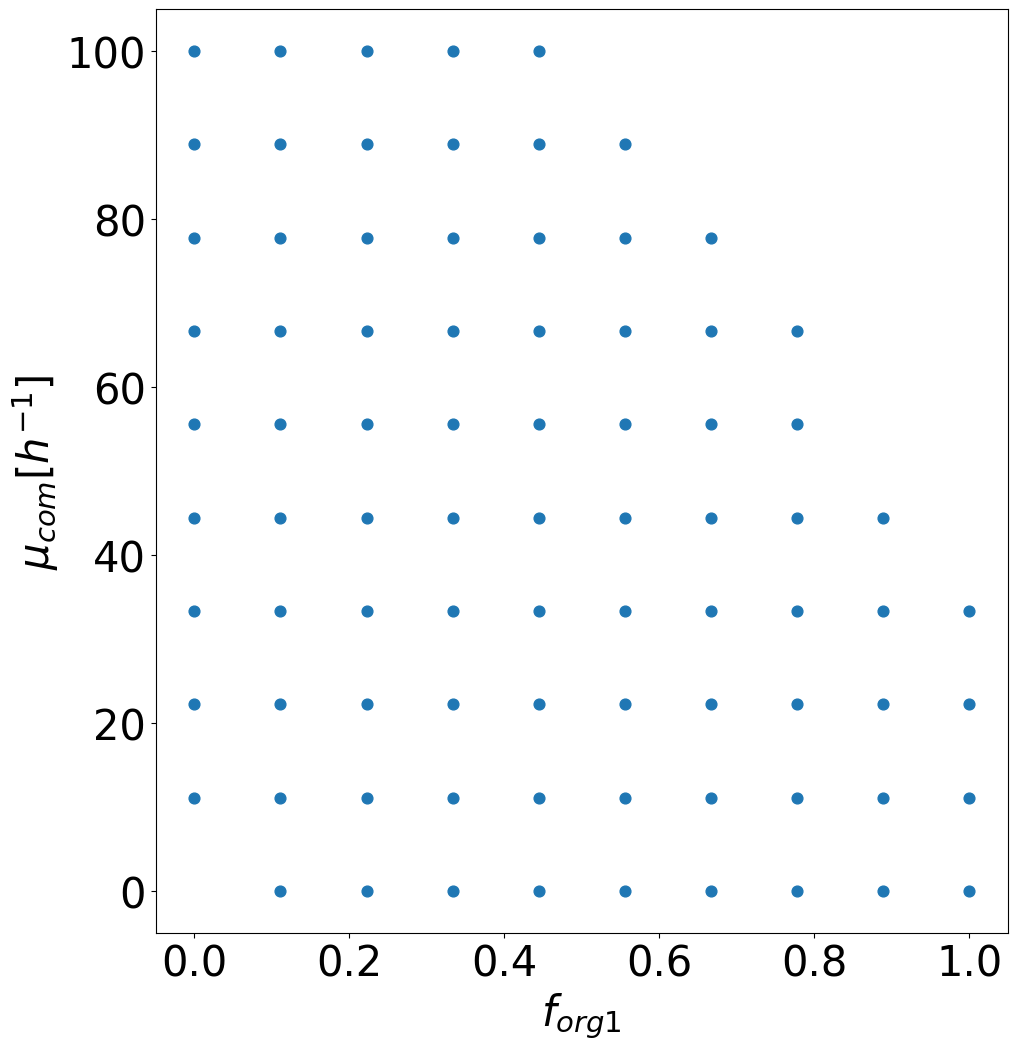

In [13]:
plt.rcParams.update({'font.size': 30})

eco2_model.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20',s=60, figsize=(11,12), 
                         to_plot = None, show_edge=False,frac_prefix= None,
                            xlabel = '$f_{org1}$',
                            ylabel ='$\mu_{com}[h^{-1}]$', saveFile = 'grid')#, fractions=[0.6,0.4],  )

## Clustering

Parameters for function **clusterPoints**:
- **method**: method used for clustering. Default: *hierarchical* clustering with Jaccard distance.
- **numeric_delta**: difference between flux values accepted as zero(default: 1e-4).
- **k**: number of clusters to be obbtained (default: 20).

In [14]:
eco2_model.clusterPoints('hierarchical', k = 8)

Calculating jaccard distances between grid points...
Clustering grid points ...
hierarchical, 8, [[  0.           1.           0.           2.        ]
 [  2.          82.           0.           3.        ]
 [  3.          83.           0.           4.        ]
 [  4.          84.           0.           5.        ]
 [  5.          85.           0.           6.        ]
 [  6.          86.           0.           7.        ]
 [  7.          87.           0.           8.        ]
 [  9.          19.           0.           2.        ]
 [ 29.          89.           0.           3.        ]
 [ 39.          90.           0.           4.        ]
 [ 48.          91.           0.           5.        ]
 [ 56.          92.           0.           6.        ]
 [ 64.          93.           0.           7.        ]
 [ 71.          94.           0.           8.        ]
 [ 10.          11.           0.           2.        ]
 [ 12.          96.           0.           3.        ]
 [ 13.          97.    

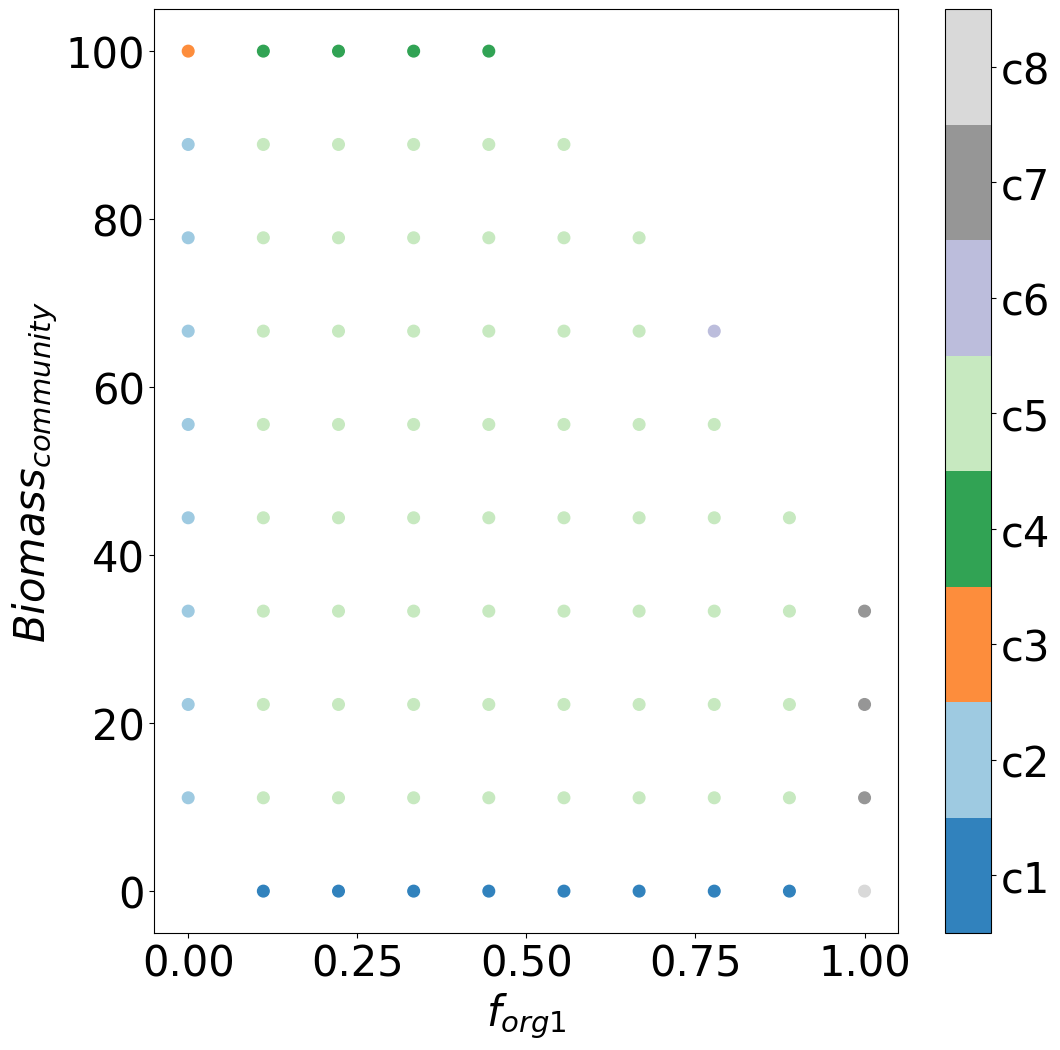

In [15]:
eco2_model.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20c',s=70, figsize=(12,12), 
                         to_plot = 'cluster', show_edge=False,frac_prefix= None,
                            xlabel = '$f_{org1}$',
                            ylabel ='$Biomass_{community}$', saveFile='clusters_toy')



Qualitative changes in this system are associated with increased biomass production and changes in community composition. For instance structural plasticity (-0) of organism 1 is gradually replaced by flux plasticity (--) while increasing biomass requirements.

To search for reactions that change their qualitative values between two clusters:

**1. Select representative values for each reaction on each cluster**:

The function **get_cluster_reaction_values** gives a DataFrame where each column is a cluster and each row a reaction. For each reaction it stores its representative value (for each cluster), in other words a qualitative vaues that represts over a threshold fraction of the points of the cluster. If there are no enough points in a cluster where a certain qualitative state is exhibited the cell is filled with a *NaN* value.
    
Parameters of **get_cluster_reaction_values**:
- **thr**:  Minimum fraction of cluster points where a reaction should have the same qualitative state to be considered representative (default value: 0.75) 
- **changing**: Fill the DataFrame only with reactions which representative values are different in at least 2 clusters (default: True).
    
**2. Select reactions with qualitative representative values between two clusters:**    
  
The function **compare_clusters** gives a DataFrame with reactions and their status that change between two specific clusters.

Parameters **get_cluster_reactions**:
- **cluster_df**: DataFrame generated by  **get_cluster_reaction_values**
- **cid1, cid2**: Ids of clusters to be compared


In [16]:
df = eco2_model.get_cluster_reaction_values(thr=0.8, changing= True)


In [17]:
df

,c1,c2,c3,c4,c5,c6,c7,c8
EX_A_e,-0,--,-,-,--,-,--,0
EX_B_e,0+,0+,0,0,0+,0,0,0
EX_biom1_c,0,0,0,+,+,+,+,0
EX_biom2_c,0,+,+,+,+,+,0,0
org1_EX_A,0,0,0,0,-0,-,--,0
org1_EX_B,0,0,0,-,NaN,-,0,0
org2_EX_A,-0,--,-,-,--,-,0,0
org2_EX_B,0+,0+,0,+,NaN,+,0,0


In [18]:
df = eco2_model.get_cluster_reaction_values(thr=0.8, changing= True)
cat_dict = {-3.0: '-', -2.0: '--',-1.0: '-0',1.0: '0+',0.0: '0',2.0: '++',3.0: '+',4.0: '-+',5.0: 'err',100.0: 'var'}
df = df.replace(cat_dict)
df

,c1,c2,c3,c4,c5,c6,c7,c8
EX_A_e,-0,--,-,-,--,-,--,0
EX_B_e,0+,0+,0,0,0+,0,0,0
EX_biom1_c,0,0,0,+,+,+,+,0
EX_biom2_c,0,+,+,+,+,+,0,0
org1_EX_A,0,0,0,0,-0,-,--,0
org1_EX_B,0,0,0,-,NaN,-,0,0
org2_EX_A,-0,--,-,-,--,-,0,0
org2_EX_B,0+,0+,0,+,NaN,+,0,0


For example, if we want to compare what are cualitative changes that occur between shifting from one cluster to another (cluster 3 and cluster 4):

In [19]:
df_comp = eco2_model.compare_clusters(df, 'c3','c4')

df_comp

,c3,c4
EX_biom1_c,0,+
org1_EX_B,0,-
org2_EX_B,0,+


# Quantitative Flux Coupling Analysis

In [20]:
grid_x = [0.2, 0.4, 0.6, 0.8]
grid_y = reversed([20, 40, 60])
rxns_analysis = ['org1_EX_A', 'org2_EX_A']
eco2_model.quan_FCA(grid_x, grid_y, rxns_analysis)

Quantitative Flux Coupling analysis 
 Initializing grid...
the closest point to [0.2, 60] is [ 0.22222222 55.55555556], at a distance of 4.4444999996527805
the closest point to [0.4, 60] is [ 0.44444444 55.55555556], at a distance of 4.444666661111387
the closest point to [0.6, 60] is [ 0.55555556 55.55555556], at a distance of 4.444666661111387
the closest point to [0.8, 60] is [ 0.77777778 55.55555556], at a distance of 4.4444999996527805
the closest point to [0.2, 40] is [ 0.22222222 44.44444444], at a distance of 4.4444999996527805
the closest point to [0.4, 40] is [ 0.44444444 44.44444444], at a distance of 4.444666661111387
the closest point to [0.6, 40] is [ 0.55555556 44.44444444], at a distance of 4.444666661111387
the closest point to [0.8, 40] is [ 0.77777778 44.44444444], at a distance of 4.4444999996527805
the closest point to [0.2, 20] is [ 0.22222222 22.22222222], at a distance of 2.2223333305556934
the closest point to [0.4, 20] is [ 0.44444444 22.22222222], at a distan

/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmp9rusf92i.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmphkt5yp9d.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmp36xvo_jb.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
Selected point[ 0.44444444 55.55555556]
This point coords [ 0.44444444 55.55555556]
This point frac [np.float64(0.4444444444444444), np.float64(0.5555555555555556)]
Old grid point [np.float64(24.691358024691358), np.float64(30.8641975308642)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmp9mh4miqf.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmpz3m1x63v.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmp_08rpxl6.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Selected point[ 0.55555556 55.55555556]
This point coords [ 0.55555556 55.55555556]
This point frac [np.float64(0.5555555555555556), np.float64(0.4444444444444444)]
Old grid point [np.float64(30.8641975308642), np.float64(24.691358024691358)]
Read LP format model from file /tmp/tmpv2x81bhq.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmpg27xyk67.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpqxbhltuk.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Selected point[ 0.77777778 55.55555556]
This point coords [ 0.77777778 55.55555556]
This point frac [np.float64(0.7777777777777777), np.float64(0.22222222222222232)]
Old grid point [np.float64(43.20987654320987), np.float64(12.345679012345684)]
Read LP format model from file /tmp/tmpfrelfzu6.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Read LP format model from file /tmp/tmprwosbvn0.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmp6_xl5f9v.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
Selected point[ 0.22222222 44.44444444]
This point coords [ 0.22222222 44.44444444]
This point frac [np.float64(0.2222222222222222), np.float64(0.7777777777777778)]
Old grid point [np.float64(9.876543209876543), np.float64(34.5679012345679)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmpfdhb09l1.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmp743ts9qi.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpy6enwuop.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
Selected point[ 0.44444444 44.44444444]
This point coords [ 0.44444444 44.44444444]
This point frac [np.float64(0.4444444444444444), np.float64(0.5555555555555556)]
Old grid point [np.float64(19.753086419753085), np.float64(24.691358024691358)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmp7g5m5df_.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmpkpsaw3k1.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpvsgb2gkb.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Selected point[ 0.55555556 44.44444444]
This point coords [ 0.55555556 44.44444444]
This point frac [np.float64(0.5555555555555556), np.float64(0.4444444444444444)]
Old grid point [np.float64(24.691358024691358), np.float64(19.753086419753085)]
Read LP format model from file /tmp/tmppbm1pqh0.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmpudqh3tod.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpdxd7hunf.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Selected point[ 0.77777778 44.44444444]
This point coords [ 0.77777778 44.44444444]
This point frac [np.float64(0.7777777777777777), np.float64(0.22222222222222232)]
Old grid point [np.float64(34.5679012345679), np.float64(9.876543209876548)]
Read LP format model from file /tmp/tmpvz__l0w_.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmpphsig2kj.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpi77b2wfi.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Selected point[ 0.22222222 22.22222222]
This point coords [ 0.22222222 22.22222222]
This point frac [np.float64(0.2222222222222222), np.float64(0.7777777777777778)]
Old grid point [np.float64(4.938271604938271), np.float64(17.28395061728395)]
Read LP format model from file /tmp/tmpf882vmkr.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Read LP format model from file /tmp/tmpt6pg1esq.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpsg1f725u.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
Selected point[ 0.44444444 22.22222222]
This point coords [ 0.44444444 22.22222222]
This point frac [np.float64(0.4444444444444444), np.float64(0.5555555555555556)]
Old grid point [np.float64(9.876543209876543), np.float64(12.345679012345679)]


/home/chuckolate/ecosystem/full_ecosystem.py:1605: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

Read LP format model from file /tmp/tmpp276ckbk.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmpz_zs6lff.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpv8ib3dhc.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Selected point[ 0.55555556 22.22222222]
This point coords [ 0.55555556 22.22222222]
This point frac [np.float64(0.5555555555555556), np.float64(0.4444444444444444)]
Old grid point [np.float64(12.345679012345679), np.float64(9.876543209876543)]
Read LP format model from file /tmp/tmpbasioapk.lp
Reading time = 0.00 seconds
: 18 rows, 46 columns, 84 nonzeros
Read LP format model from file /tmp/tmpegn5fegn.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpwa4a6yud.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Selected point[ 0.77777778 22.22222222]
This point coords [ 0.77777778 22.22222222]
This point frac [np.float64(0.7777777777777777), np.float64(0.22222222222222232)]
Old grid point [np.float64(17.28395061728395), np.float64(4.938271604938274)]


/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
/home/chuckolate/ecosystem/full_ecosystem.py:1618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

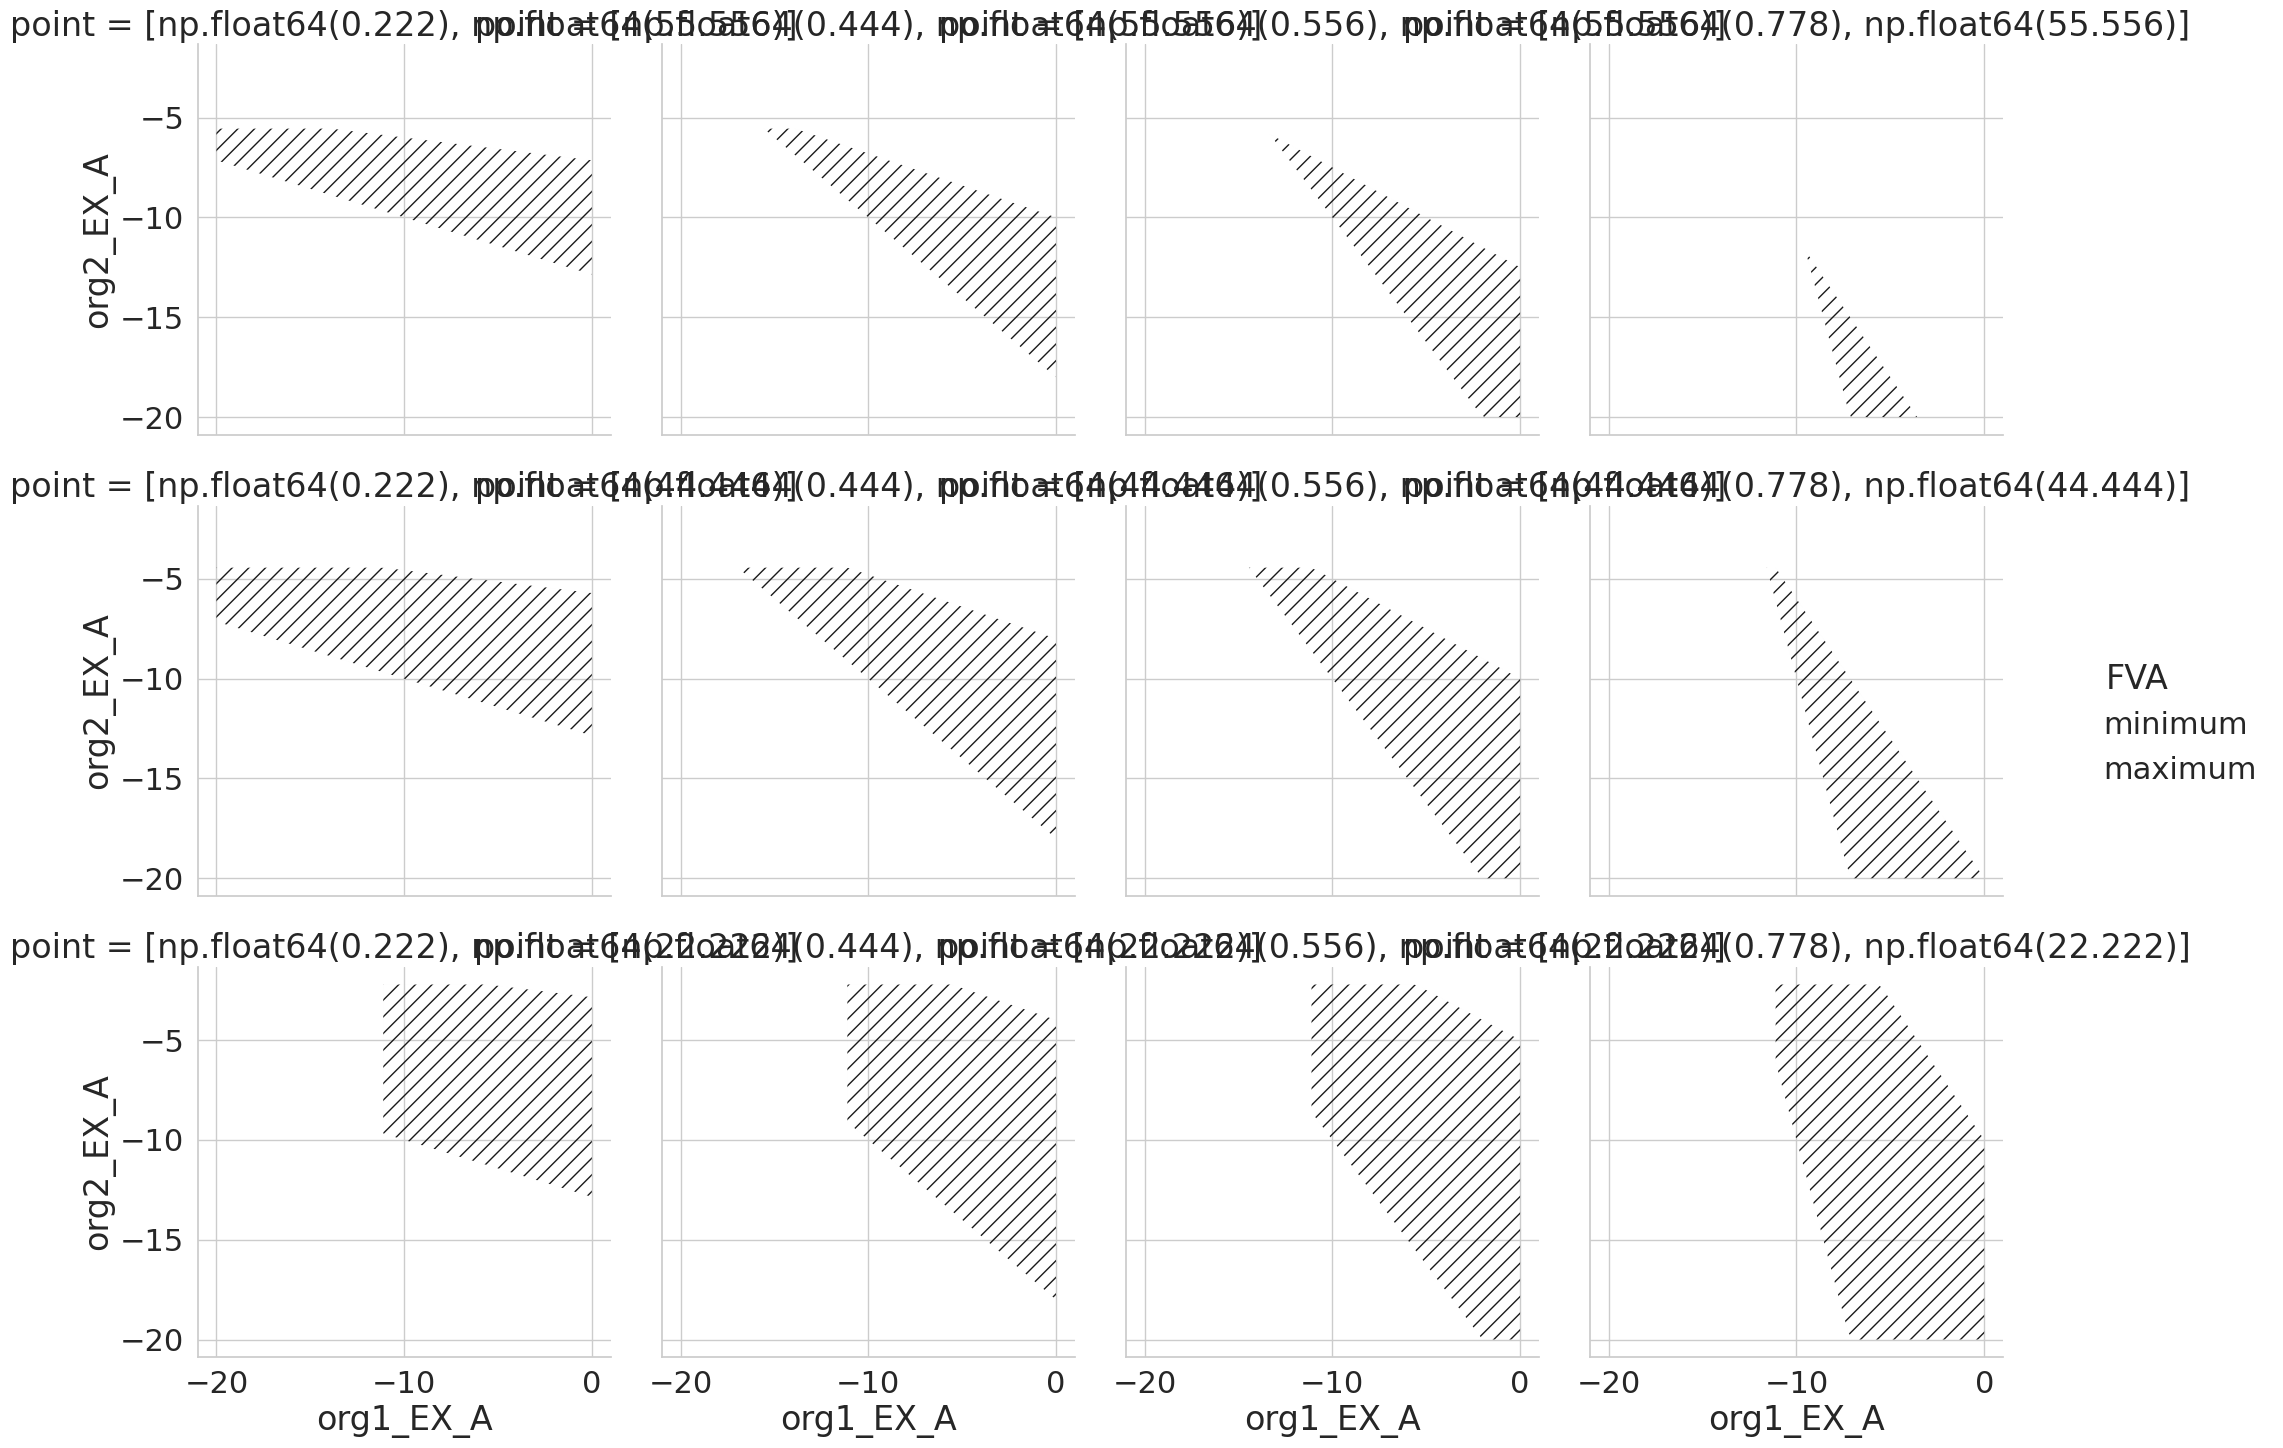

In [21]:
eco2_model.plot_qFCA()